### CNN-LSTM model
#### mixed architecture using both, convolutional layers and LSTM layers, alternately, to predict litter moisture. First, we trained the model with manually selected hyperparameters, then using the Optun framework, we searched for hyperparameters to find the best perforating architecture.

In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import optuna
import tensorflow as tf
from litter import WindowGenerator
from matplotlib.gridspec import GridSpec
from optuna.integration import TFKerasPruningCallback
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("bmh")

In [4]:
# WindowGenerator params
DATA_PATH = "../stations"
SCALING = "standarization"  # 'normalization'
GAP_STRATEGY = "linear"
FIRST_SEASON = 2015
FIRST_VAL_SEASON = 2021
FIRST_TEST_SEASON = 2022
LAST_TEST_SEASON = 2022

# data generator params
FEATURES = [
    "air_temperature_50cm",
    "air_temperature_200cm",
    "air_humidity_50cm",
    "air_humidity_200cm",
    "wind_x",
    "wind_y",
    "max_wind_x",
    "max_wind_y",
    "temporary_rainfall",
    "total_precipitation",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]
DATA_FORMAT = "channels_last"
INTERVALS = [3, 6, 6 * 2, 6 * 4, 6 * 24, 6 * 24 * 12]
BASE_SEQ_LEN = 30
OTHER_SEQ_LEN = [30, 30, 30, 30, 30, 30]
INCLUDE_COORDS = True
USE_PREVIOUS_Y = True
REPLACE = False

# training params
BATCH_SIZE = 32

In [5]:
wg = WindowGenerator(
    data_path=DATA_PATH,
    scaling=SCALING,
    gap_strategy=GAP_STRATEGY,
    first_train_season=FIRST_SEASON,
    first_val_season=FIRST_VAL_SEASON,
    first_test_season=FIRST_TEST_SEASON,
    last_test_season=LAST_TEST_SEASON,
)

In [6]:
(train_x, train_y), (val_x, val_y), (test_x, test_y), length_stats = wg.get_data(
    batch_size=BATCH_SIZE,
    data_format=DATA_FORMAT,
    intervals=INTERVALS,
    base_seq_len=BASE_SEQ_LEN,
    other_seq_len=OTHER_SEQ_LEN,
    features_cols=FEATURES,
    include_coords=INCLUDE_COORDS,
    use_previous_y=USE_PREVIOUS_Y,
    replace=REPLACE,
    train_generator=False,
    val_generator=False,
    test_generator=False,
)

data format: channels_last
641
641 641 641
370
370 370 370
1586
1586 1586 1586
1324
1324 1324 1324
1673
1673 1673 1673
1279
1279 1279 1279
711
711 711 711
431
431 431 431
266
266 266 266
219
219 219 219
1945
1945 1945 1945
1209
1209 1209 1209
1407
1407 1407 1407
966
966 966 966
1033
1033 1033 1033
0
0 0 0
879
879 879 879
505
505 505 505
1197
1197 1197 1197
750
750 750 750
868
868 868 868
608
608 608 608
875
875 875 875
550
550 550 550
1617
1617 1617 1617
1126
1126 1126 1126
2035
2035 2035 2035
1673
1673 1673 1673
1993
1993 1993 1993
1225
1225 1225 1225
1968
1968 1968 1968
1240
1240 1240 1240
1107
1107 1107 1107
767
767 767 767
2006
2006 2006 2006
1409
1409 1409 1409
1834
1834 1834 1834
1074
1074 1074 1074
165
165 165 165
69
69 69 69
1178
1178 1178 1178
532
532 532 532
1603
1603 1603 1603
1028
1028 1028 1028
1879
1879 1879 1879
907
907 907 907
1327
1327 1327 1327
766
766 766 766
1774
1774 1774 1774
1091
1091 1091 1091
1889
1889 1889 1889
1270
1270 1270 1270
2009
2009 2009 2009
1589
1589

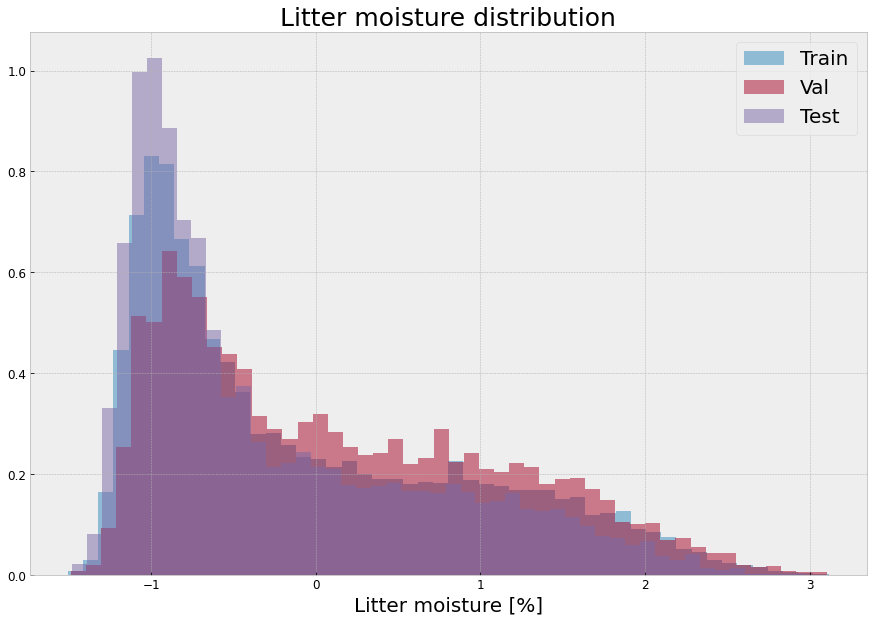

In [7]:
fig, ax = plt.subplots()


ax.hist(train_y, bins=50, density=True, label="Train", alpha=0.5)
ax.hist(val_y, bins=50, density=True, label="Val", alpha=0.5)
ax.hist(test_y, bins=50, density=True, label="Test", alpha=0.5)

plt.title("Litter moisture distribution", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Litter moisture [%]", fontsize=20)
plt.legend(fontsize=20)

plt.savefig("litter_moisture.svg")

In [8]:
if SCALING == "normalization":
    train_y = (
        (wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]) * train_y
    ) + wg.train_min["litter_moisture"]
    val_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_y + wg.train_min["litter_moisture"]
    test_y = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_y + wg.train_min["litter_moisture"]

    y_morning_train = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * train_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_val = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * val_x[0][:, 0] + wg.train_min["litter_moisture"]
    y_morning_test = (
        wg.train_max["litter_moisture"] - wg.train_min["litter_moisture"]
    ) * test_x[0][:, 0] + wg.train_min["litter_moisture"]

elif SCALING == "standarization":
    train_y = (
        train_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    )
    val_y = val_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]
    test_y = test_y * wg.train_std["litter_moisture"] + wg.train_mean["litter_moisture"]

    y_morning_train = (
        train_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_val = (
        val_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )
    y_morning_test = (
        test_x[0][:, 0] * wg.train_std["litter_moisture"]
        + wg.train_mean["litter_moisture"]
    )

else:
    y_morning_train = train_x[0][:, 0]
    y_morning_val = val_x[0][:, 0]
    y_morning_test = test_x[0][:, 0]

pct_change_train = (train_y - y_morning_train) / y_morning_train * 100
pct_change_val = (val_y - y_morning_val) / y_morning_val * 100
pct_change_test = (test_y - y_morning_test) / y_morning_test * 100

pct_change_mean = pct_change_train.mean()
pct_change_std = pct_change_train.std()

pct_change_standarized_train = (pct_change_train - pct_change_mean) / pct_change_std
pct_change_standarized_val = (pct_change_val - pct_change_mean) / pct_change_std
pct_change_standarized_test = (pct_change_test - pct_change_mean) / pct_change_std

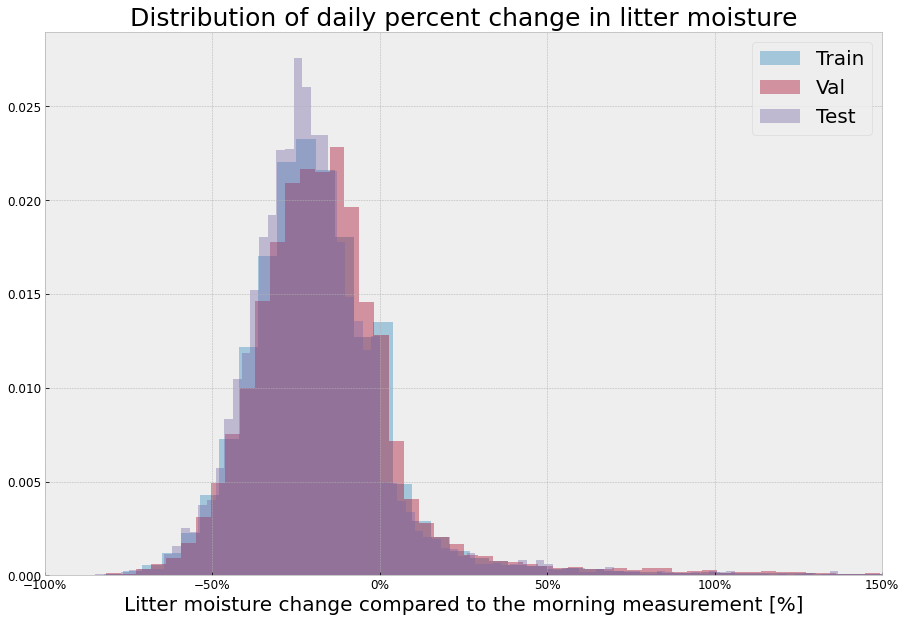

In [9]:
fig, ax = plt.subplots()

ax.hist(pct_change_train, bins=200, density=True, label="Train", alpha=0.4)
ax.hist(pct_change_val, bins=200, density=True, label="Val", alpha=0.4)
ax.hist(pct_change_test, bins=200, density=True, label="Test", alpha=0.4)

plt.xlim([-100, 150])
plt.title("Distribution of daily percent change in litter moisture", fontsize=25)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax.set_xlabel(
    "Litter moisture change compared to the morning measurement [%]", fontsize=20
)
plt.legend(fontsize=20)
plt.savefig("litter_moisture_change.svg")

In [14]:
def get_conv_lstm_model():

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    lstm_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):

        conv_1 = tf.keras.layers.Conv1D(
            32, 3, padding="same", activation="relu", name=f"conc_{str(i)}_1"
        )

        lstm_1 = tf.keras.layers.LSTM(
            16,
            return_sequences=True,
            name=f"lstm_{str(i)}_1",
            recurrent_dropout=0,
            dropout=0.5,
        )

        conv_2 = tf.keras.layers.Conv1D(
            64, 3, padding="same", activation="relu", name=f"conc_{str(i)}_2"
        )

        lstm_2 = tf.keras.layers.LSTM(
            32,
            return_sequences=True,
            name=f"lstm_{str(i)}_2",
            recurrent_dropout=0,
            dropout=0.5,
        )

        conv_3 = tf.keras.layers.Conv1D(
            128, 3, padding="same", activation="relu", name=f"conv_{str(i)}_3"
        )

        lstm_3 = tf.keras.layers.LSTM(
            64,
            return_sequences=False,
            name=f"lstm_{str(i)}_3",
            recurrent_dropout=0,
            dropout=0.5,
        )

        x = conv_1(sequence_input)
        x = tf.keras.layers.Bidirectional(lstm_1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = conv_2(x)
        x = tf.keras.layers.MaxPool1D()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Bidirectional(lstm_2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = conv_3(x)
        x = tf.keras.layers.MaxPool1D()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Bidirectional(lstm_3)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        lstm_blocks.append(x)

    # concatenate all lstm_blocks, and optionally dense data
    if dense_inputs is not None:
        concat = tf.keras.layers.concatenate(
            [dense_inputs, *lstm_blocks], name="concatenate"
        )
    else:
        concat = tf.keras.layers.concatenate(lstm_blocks, name="concatenate")

    dense1 = tf.keras.layers.Dense(256, activation="relu")(concat)
    batchnorm1 = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = tf.keras.layers.Dense(64, activation="relu")(batchnorm1)
    batchnorm2 = tf.keras.layers.BatchNormalization()(dense2)

    outputs = tf.keras.layers.Dense(1)(batchnorm2)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model

In [15]:
model = get_conv_lstm_model()
model.summary()

2022-10-03 13:50:26.551640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:50:26.552788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 13:50:26.556386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 13:50:26.558979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input_0 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_1 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_2 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                                  
 seq_input_3 (InputLayer)       [(None, 30, 14)]     0           []                               
                                                                                              

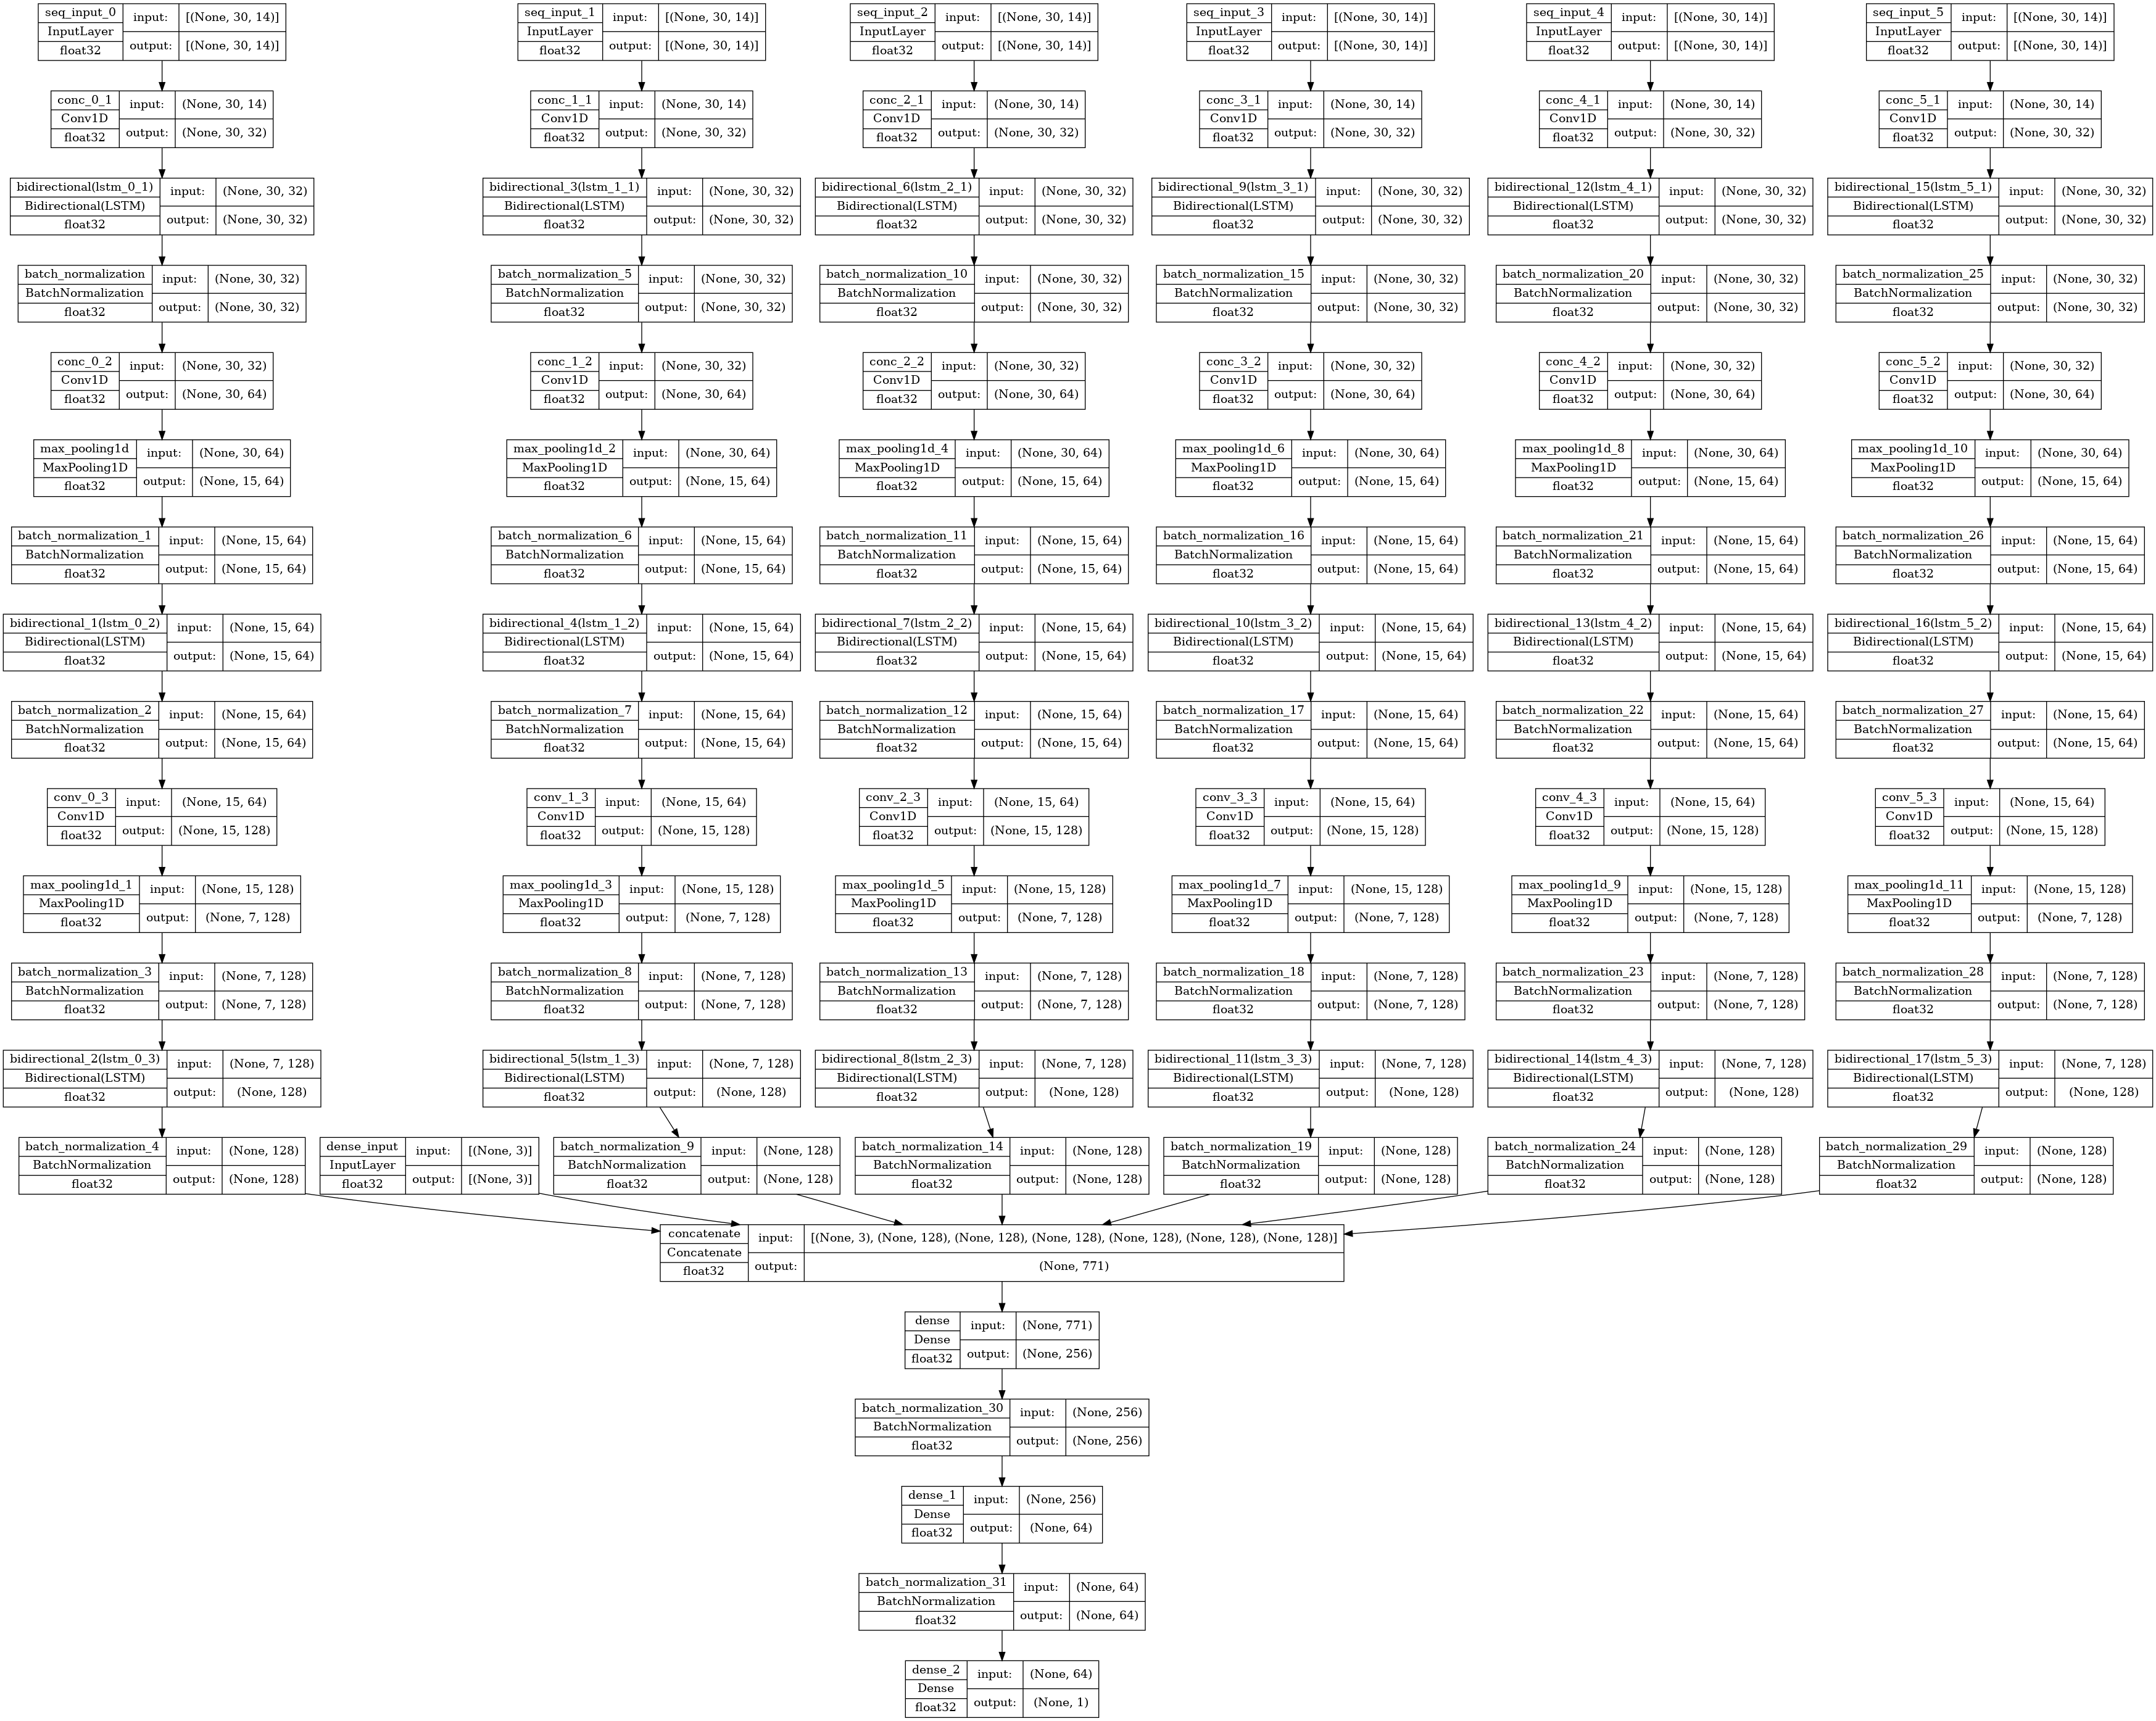

In [16]:
tf.keras.utils.plot_model(
    model,
    "model.png",
    show_shapes=True,
    show_dtype=True,
)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.Huber(0.65),
)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=7,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(
    x=train_x,
    y=pct_change_standarized_train,
    epochs=500,
    validation_data=(val_x, pct_change_standarized_val),
    callbacks=[es],
)

Epoch 1/500


2022-10-03 13:51:27.542348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1904/1904 [==============================] - 217s 86ms/step - loss: 0.2333 - val_loss: 0.2035
Epoch 2/500
1904/1904 [==============================] - 152s 80ms/step - loss: 0.1771 - val_loss: 0.1866
Epoch 3/500
1904/1904 [==============================] - 152s 80ms/step - loss: 0.1690 - val_loss: 0.1752
Epoch 4/500
1904/1904 [==============================] - 152s 80ms/step - loss: 0.1637 - val_loss: 0.1723
Epoch 5/500
1904/1904 [==============================] - 151s 80ms/step - loss: 0.1580 - val_loss: 0.1652
Epoch 6/500
1904/1904 [==============================] - 152s 80ms/step - loss: 0.1531 - val_loss: 0.1577
Epoch 7/500
1904/1904 [==============================] - 152s 80ms/step - loss: 0.1489 - val_loss: 0.1573
Epoch 8/500
1904/1904 [==============================] - 153s 81ms/step - loss: 0.1442 - val_loss: 0.1564
Epoch 9/500
1904/1904 [==============================] - 150s 79ms/step - loss: 0.1414 - val_loss: 0.1516
Epoch 10/500
1620/1904 [========================>.....] - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1904/1904 [==============================] - 152s 80ms/step - loss: 0.1367 - val_loss: 0.1479
Epoch 12/500
1904/1904 [==============================] - 151s 79ms/step - loss: 0.1348 - val_loss: 0.1446
Epoch 13/500
1904/1904 [==============================] - 151s 79ms/step - loss: 0.1329 - val_loss: 0.1474
Epoch 14/500
1904/1904 [==============================] - 151s 79ms/step - loss: 0.1315 - val_loss: 0.1525
Epoch 15/500
 324/1904 [====>.........................] - ETA: 1:57 - loss: 0.1313

In [ ]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

In [ ]:
delta = test_predictions - pct_change_standarized_test
print(delta.std())
_ = plt.hist(delta, bins=100)

In [ ]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

print(pct_change_predicted[:100])

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"CONV-LSTM model: mae: {round(mae, 3)}%, mse: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=25)
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)

error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=25)
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)

In [ ]:
# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"CONV-LSTM model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.05)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=100, density=True)
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)

error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=25, density=True)
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)

plt.savefig("results_error_show_conv_lstm.svg")

In [ ]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(y_real, y_pred, c=z, s=100, alpha=0.5)
ax_hist_x.hist(y_real, orientation="horizontal", bins=50, density=True)
ax_hist_y.hist(y_pred, bins=50, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_xlabel("Real", fontsize=20)
ax_scatter.set_ylabel("Predicted", fontsize=20)
plt.show()

plt.savefig("results_boundary_distribution_conv_lstm.svg")

In [ ]:
_ = plt.hist(y_real, bins=50, density=True, alpha=0.5, label="Real value")
_ = plt.hist(y_pred, bins=50, density=True, alpha=0.5, label="Predicted")
plt.legend(fontsize=20)

plt.savefig("results_distribution_conv_lstm.svg")

In [ ]:
tf.keras.models.save_model(model, "best_custom_conv_lstm_pct_std")

In [ ]:
def create_model(trial):

    if OTHER_SEQ_LEN:
        sequences_n = OTHER_SEQ_LEN
    else:
        sequences_n = [BASE_SEQ_LEN for _ in range(INTERVALS)]

    features_n = len(FEATURES)
    sequence_inputs = [
        tf.keras.Input(shape=(seq_n, features_n), name=f"seq_input_{str(i)}")
        for i, seq_n in enumerate(sequences_n)
    ]
    dense_inputs_len = 1 if USE_PREVIOUS_Y else 0
    dense_inputs_len += 2 if INCLUDE_COORDS else 0
    if dense_inputs_len:
        dense_inputs = tf.keras.Input(shape=(dense_inputs_len), name="dense_input")
    else:
        dense_inputs = None

    # We optimize the numbers of layers, their units, dropout ratio and weight decay parameter.
    n_conv_lstm_layers = trial.suggest_int("n_conv_lstm_layers", 1, 4)
    n_dense_layers = trial.suggest_int("n_dense_layers", 0, 4)

    conv_lstm_blocks = []
    for i, sequence_input in enumerate(sequence_inputs):
        x = sequence_input
        for j in range(n_conv_lstm_layers):

            num_filters_1 = trial.suggest_categorical(
                "n_units_conv1_{}_{}".format(i, j), [32, 64, 128, 256]
            )
            return_sequences = j != n_conv_lstm_layers - 1
            is_bidirectional = trial.suggest_categorical(
                "is_bidirectional_lstm_{}_{}".format(i, j), [True, False]
            )
            num_lstm = trial.suggest_categorical(
                "n_units_lstm_{}_{}".format(i, j), [32, 64, 128, 256]
            )
            dropout_rate = trial.suggest_float(
                "dropout_ratio_lstm_{}_{}".format(i, j), 0.0, 0.3
            )

            x = tf.keras.layers.Conv1D(
                num_filters_1,
                3,
                padding="same",
                activation="relu",
                name=f"conv_{str(i)}_{str(j)}_1",
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
            lstm_layer = tf.keras.layers.LSTM(
                num_lstm,
                return_sequences=return_sequences,
                name=f"lstm_{str(i)}_{str(j)}",
                dropout=dropout_rate,
            )
            if is_bidirectional:
                x = tf.keras.layers.Bidirectional(lstm_layer)(x)
            else:
                x = lstm_layer(x)

            if return_sequences:
                x = tf.keras.layers.MaxPool1D()(x)

        conv_lstm_blocks.append(x)

    # concatenate all conv_lstm_blocks, and optionally dense data
    if dense_inputs is not None:
        x = tf.keras.layers.concatenate(
            [dense_inputs, *conv_lstm_blocks], name="concatenate"
        )
    else:
        x = tf.keras.layers.concatenate(conv_lstm_blocks, name="concatenate")

    for i in range(n_dense_layers):
        num_hidden = trial.suggest_categorical("n_units_l{}".format(i), [32, 64, 128])
        dense = tf.keras.layers.Dense(
            num_hidden,
            activation="relu",
        )
        x = dense(x)
        x = tf.keras.layers.BatchNormalization()(x)

    if not n_dense_layers:
        x = tf.keras.layers.BatchNormalization()(x)

    outputs = tf.keras.layers.Dense(1)(x)
    if dense_inputs is not None:
        model = tf.keras.models.Model(
            inputs=[dense_inputs, *sequence_inputs], outputs=outputs
        )
    else:
        model = tf.keras.models.Model(inputs=sequence_inputs, outputs=outputs)
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float(
            "rmsprop_momentum", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float(
            "adam_learning_rate", 5 * 1e-5, 1e-1, log=True
        )
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float(
            "sgd_opt_momentum", 5 * 1e-5, 1e-1, log=True
        )

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [ ]:
# TODO
# The method of saving to file is not the best idea,
# but for experimental purposes it is sufficient and the fastest in implementation.
# Unfortunately, there are no convenient methods to store information about the best value obtained in the optuna "trial" variable.
f = open("best_mdape_conv_lstm_pct_std.txt", "w")
f.write("10000")
f.close()

In [ ]:
def objective(trial):

    model = create_model(trial)
    optimizer = create_optimizer(trial)
    batch_size = optimizer_selected = trial.suggest_categorical("batch_size", [32, 64])
    delta = 0.65 * 1.35

    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta))

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.0001,
        patience=7,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    pruner_callback = TFKerasPruningCallback(trial, "val_loss")

    history = model.fit(
        x=train_x,
        y=pct_change_standarized_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(val_x, pct_change_standarized_val),
        callbacks=[es, pruner_callback],
    )

    val_predictions = model.predict(val_x).flatten()
    pct_change_predicted = val_predictions * pct_change_std + pct_change_mean

    y_real = y_morning_val * (1 + pct_change_val / 100)
    y_pred = y_morning_val * (1 + pct_change_predicted / 100)

    mae = np.absolute(y_real - y_pred).mean()
    rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
    mape = np.abs((y_real - y_pred) / y_real).mean() * 100
    mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100

    print(
        f"CONV-LSTM pct std model: mae: {round(mae, 3)}%, rmsd: {round(rmsd, 3)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%"
    )

    f = open("best_mdape_conv_lstm_pct_std.txt", "r")
    best_mdape = float(f.read())
    f.close()

    if mdape < best_mdape:
        print("save model")
        best_mdape = mdape
        tf.keras.models.save_model(model, "best_mdape_conv_lstm_pct_std")
        f = open("best_mdape_conv_lstm_pct_std.txt", "w")
        f.write(str(best_mdape))
        f.close()
    return mdape

In [ ]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=15),
)

In [ ]:
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [12]:
model = tf.keras.models.load_model("best_custom_conv_lstm_pct_std")

2022-10-14 12:26:59.342310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 12:26:59.344925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 12:26:59.348463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 12:26:59.351023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [13]:
test_loss = model.evaluate(test_x, pct_change_standarized_test)
print(f"test loss: {test_loss}")
test_predictions = model.predict(test_x).flatten()

2022-10-14 12:28:31.517156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


272/272 [==============================] - 23s 24ms/step - loss: 0.1393
test loss: 0.13926318287849426
272/272 [==============================] - 18s 24ms/step


In [14]:
pct_change_predicted = test_predictions * pct_change_std + pct_change_mean

y_real = y_morning_test * (1 + pct_change_test / 100)
y_pred = y_morning_test * (1 + pct_change_predicted / 100)

mae = np.absolute(y_real - y_pred).mean()
rmsd = (((y_real - y_pred) ** 2).mean()) ** 0.5
mape = np.abs((y_real - y_pred) / y_real).mean() * 100
mdape = np.median(np.abs((y_real - y_pred) / y_real)) * 100
print(mae, rmsd, mape, mdape)

3.4649810160766417 5.311814936292883 16.51317737288503 11.559726183363766


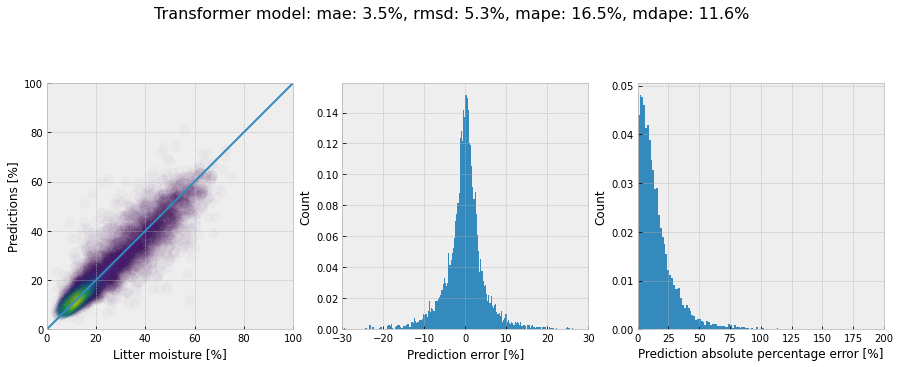

In [15]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([y_real, y_pred])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots(nrows=1, ncols=3)
_ = fig.suptitle(
    f"Transformer model: mae: {round(mae, 1)}%, rmsd: {round(rmsd, 1)}%, mape: {round(mape,1)}%, mdape: {round(mdape,1)}%",
    fontsize=16,
    y=0.78,
)

_ = ax[0].set_aspect("equal")
ax[0].scatter(y_real, y_pred, c=z, s=100, alpha=0.02)
ax[0].set_xlabel("Litter moisture [%]")
ax[0].set_ylabel("Predictions [%]")
lims = [0, 100]
ax[0].plot(lims, lims)
_ = ax[0].axis(xmin=0, xmax=100, ymin=0, ymax=100)


error = y_pred - y_real
ax[1].hist(error, bins=300, density=True)
ax[1].set_xlim([-30, 30])
ax[1].set_xlabel("Prediction error [%]")
_ = ax[1].set_ylabel("Count")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
_ = ax[1].set_aspect(asp)


error = np.absolute((y_pred - y_real) / y_real) * 100
ax[2].hist(error, bins=300, density=True)
ax[2].set_xlim([0, 200])
ax[2].set_xlabel("Prediction absolute percentage error [%]")
_ = ax[2].set_ylabel("Count")
asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
_ = ax[2].set_aspect(asp)


plt.savefig("litter_moisture_conv_lstm_test_stats2.svg")

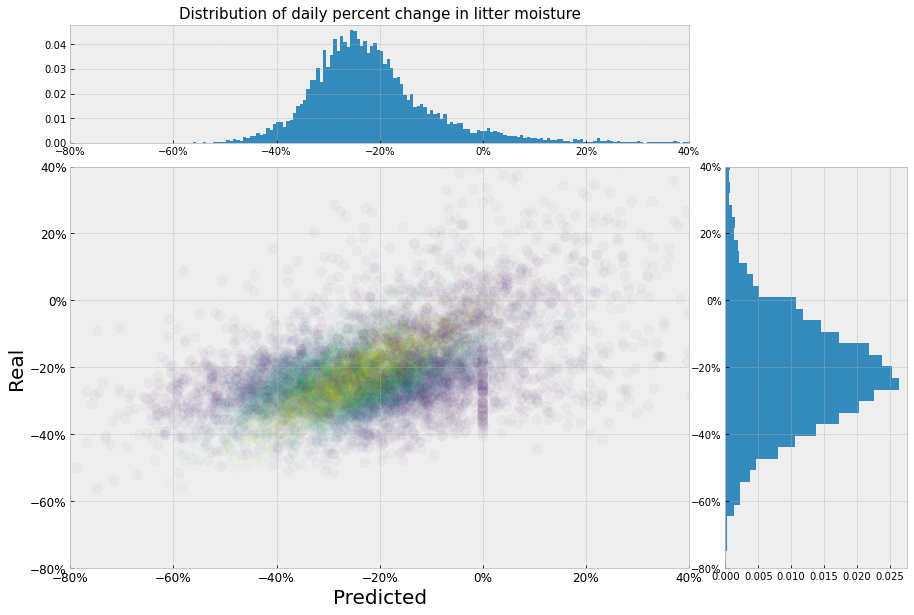

<Figure size 1080x720 with 0 Axes>

In [16]:
fig = plt.figure()
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0, 0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(pct_change_test, pct_change_predicted, c=z, s=100, alpha=0.03)
ax_hist_x.hist(pct_change_test, orientation="horizontal", bins=150, density=True)
ax_hist_y.hist(pct_change_predicted, bins=500, density=True)

ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_y.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_hist_x.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
ax_scatter.set_ylabel("Real", fontsize=20)
ax_scatter.set_xlabel("Predicted", fontsize=20)

min_val, max_val = -80, 40
ax_scatter.set_xlim([min_val, max_val])
ax_scatter.set_ylim([min_val, max_val])
ax_hist_y.set_xlim([min_val, max_val])
ax_hist_x.set_ylim([min_val, max_val])
# ax_scatter.set_aspect(1)
ax_hist_y.set_title(
    "Distribution of daily percent change in litter moisture", fontsize=15
)
ax_scatter.tick_params(axis="both", which="major", labelsize=12)
ax_scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))


plt.show()
plt.savefig("results_boundary_pct_change_distribution_conv_lstm2.svg")

(-100.0, 150.0)

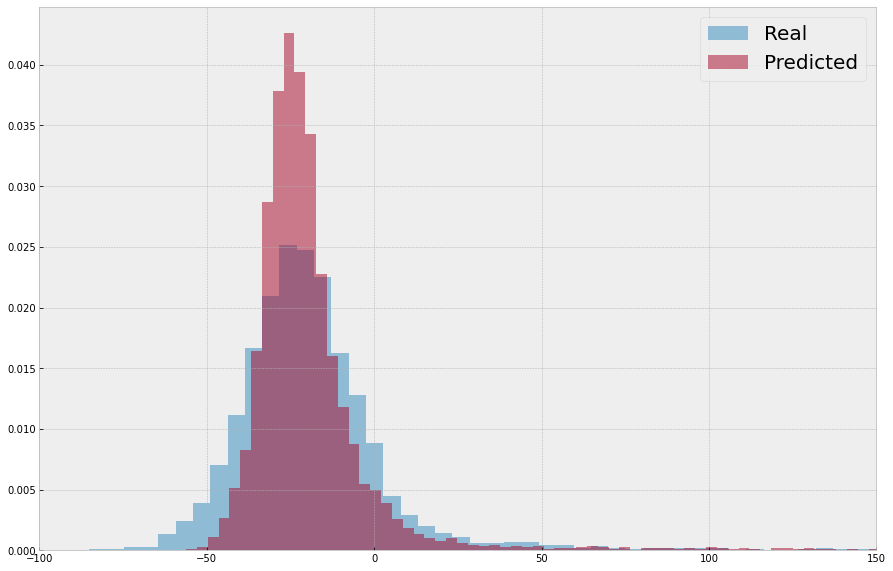

In [17]:
_ = plt.hist(pct_change_test, bins=100, density=True, alpha=0.5, label="Real")
_ = plt.hist(pct_change_predicted, bins=100, density=True, alpha=0.5, label="Predicted")
plt.legend(fontsize=20)
plt.xlim([-100, 150])